In [1]:
#import libraries
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
#open lightcurves
lc1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc')
lc2 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc')
lc3 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.lc')
lc4 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.lc')

In [4]:
#create lc data array
lc1_data = lc1[1].data
lc2_data = lc2[1].data
lc3_data = lc3[1].data
lc4_data = lc4[1].data

lc = [lc1_data, lc2_data, lc3_data, lc4_data]

In [5]:
saa_indices = np.array([np.where(lc[0].field('RATE') == 0) for i in range(0,4)])
saa_start_ind = saa_indices[0][0][0] - 1
saa_end_ind = saa_indices[0][0][-1] + 1
saa_start = lc[0].field('TIME')[saa_start_ind]
saa_end = lc[0].field('TIME')[saa_end_ind]

In [6]:
def detrend_func(lc_data, saa_start_ind, saa_end_ind):
    max_ind = int(np.where(lc_data.field('RATE') == np.max(lc_data.field('RATE')))[0])
    lc_detrend = np.zeros_like(lc_data.field('RATE'))
    lc_detrend[(max_ind-120):(max_ind+30)] = lc_data.field('RATE')[(max_ind-120):(max_ind+30)] - np.median(lc_data.field('RATE')[:(max_ind-125)])
    lc_detrend[:(max_ind-60)] = lc_data.field('RATE')[:(max_ind-60)] - signal.savgol_filter(lc_data.field('RATE')[:(max_ind-60)], 100, 2)
    lc_detrend[(max_ind+30):saa_start_ind] = lc_data.field('RATE')[(max_ind+30):saa_start_ind] - signal.savgol_filter(lc_data.field('RATE')[(max_ind+30):saa_start_ind], 100, 2)
    lc_detrend[saa_end_ind:] = lc_data.field('RATE')[saa_end_ind:] - signal.savgol_filter(lc_data.field('RATE')[saa_end_ind:], 100, 2)
    return(lc_detrend)

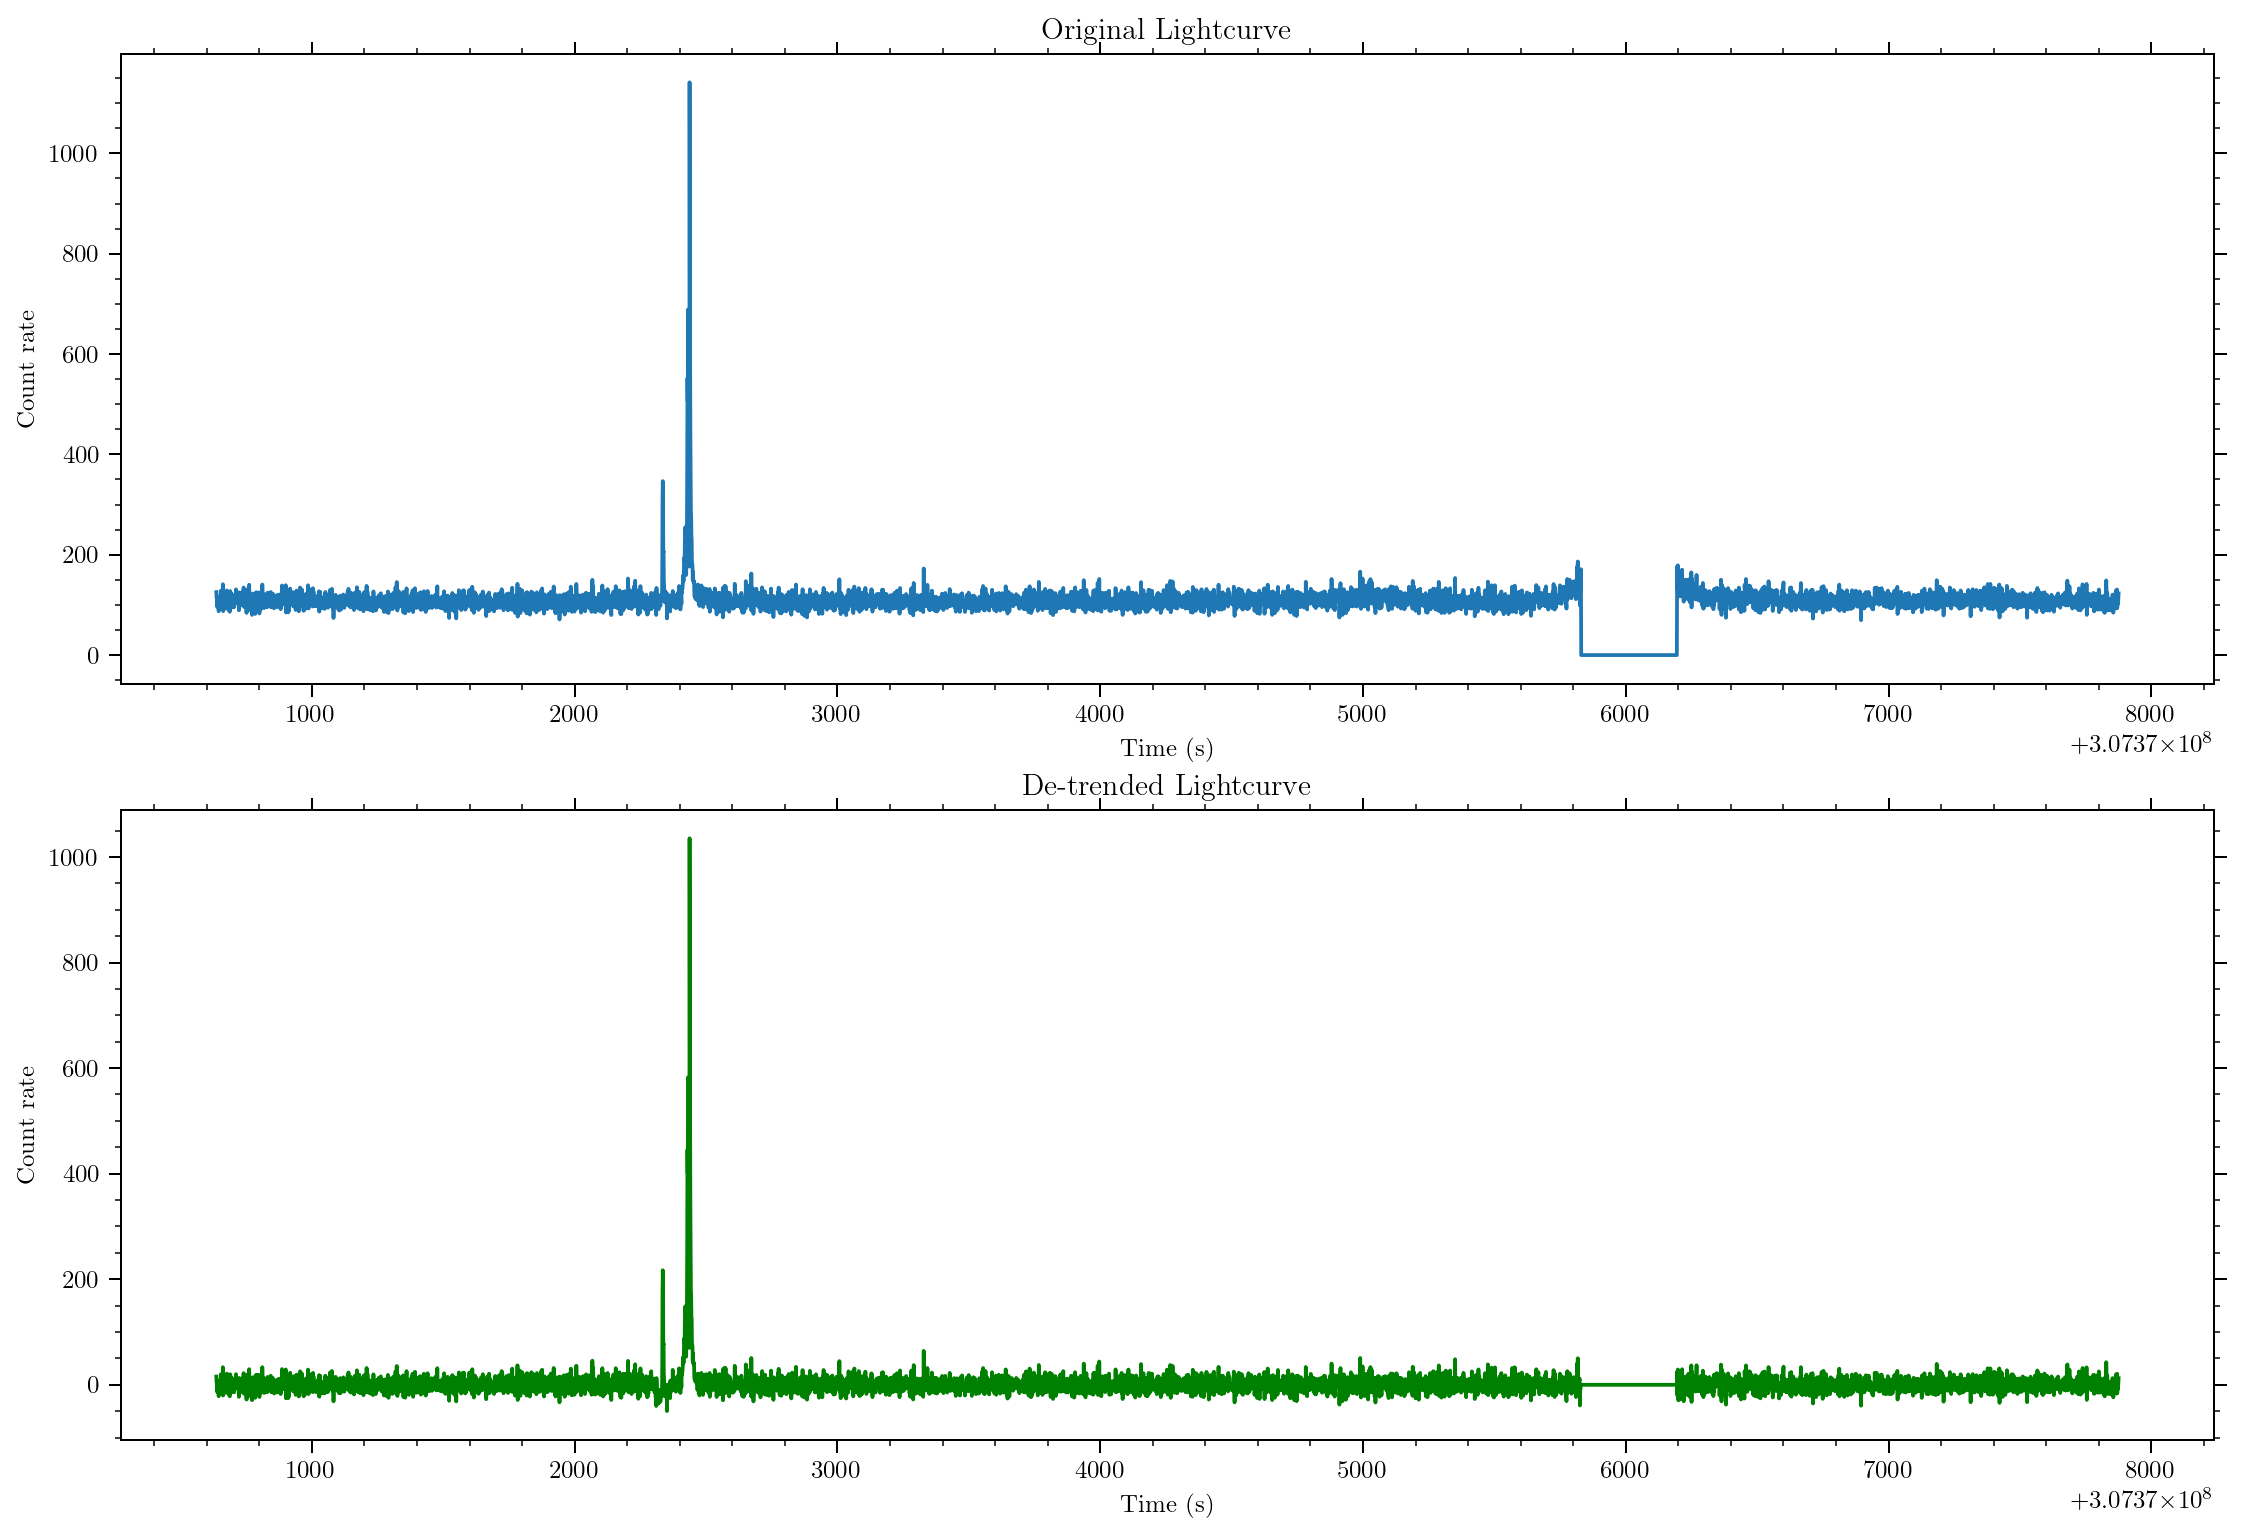

In [7]:
plt.figure(dpi=180, figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Original Lightcurve')
plt.plot(lc[0].field('TIME'), lc[0].field('RATE'))
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.subplot(2,1,2)
plt.title('De-trended Lightcurve')
plt.plot(lc[0].field('TIME'), detrend_func(lc[0], saa_start_ind, saa_end_ind), 'g')
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.show()

In [8]:
def snr_maxmin(lc_data, saa_start_ind):
    max_ind = int(np.where(lc_data == np.max(lc_data))[0])
    noise_max = np.max(lc_data[max_ind+15:saa_start_ind])
    noise_min =  np.min(lc_data[max_ind+15:saa_start_ind])
    peak = np.max(lc_data)
    return ((peak/(noise_max-noise_min)), noise_max, noise_min)

In [9]:
for i in range(0,4):
    print("[Noise Max-Min] SNR of Q"+str(i)+" = "+str(snr_maxmin(detrend_func(lc[i], saa_start_ind, saa_end_ind), saa_start_ind)[0]))

[Noise Max-Min] SNR of Q0 = 10.022328
[Noise Max-Min] SNR of Q1 = 9.723932
[Noise Max-Min] SNR of Q2 = 14.028776
[Noise Max-Min] SNR of Q3 = 10.321281


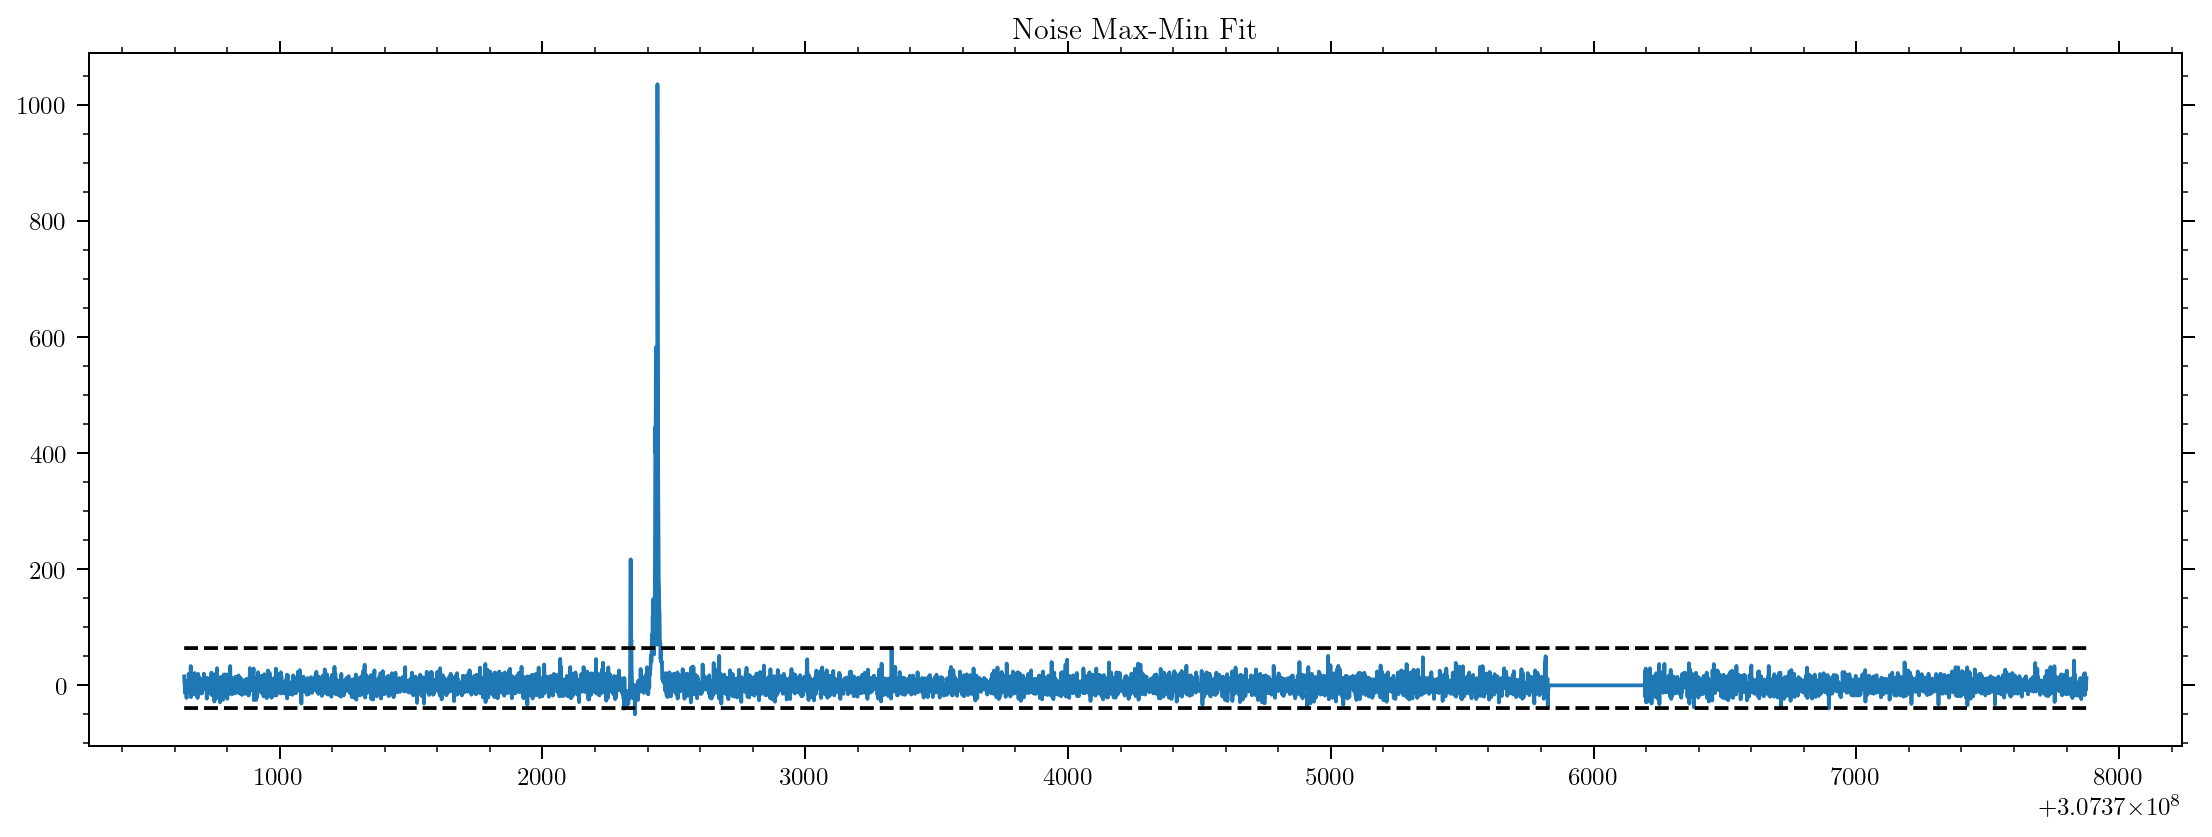

In [10]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc[0].field('TIME'), detrend_func(lc[0], saa_start_ind, saa_end_ind))
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*snr_maxmin(detrend_func(lc[0], saa_start_ind, saa_end_ind), saa_start_ind)[1], 'k--')
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*snr_maxmin(detrend_func(lc[0], saa_start_ind, saa_end_ind), saa_start_ind)[2], 'k--')
plt.title('Noise Max-Min Fit')
plt.show()

In [11]:
def snr_rms(lc_data, saa_start_ind):
    max_ind = int(np.where(lc_data == np.max(lc_data))[0])
    noise_rms = np.sqrt(np.sum(lc_data[max_ind+15:saa_start_ind]**2)/np.size(lc_data[max_ind+15:saa_start_ind]))
    peak = np.max(lc_data)
    return ((peak/noise_rms), noise_rms)

In [12]:
for i in range(0,4):
    print("[Noise RMS] SNR of Q"+str(i)+" = "+str(snr_rms(detrend_func(lc[i], saa_start_ind, saa_end_ind), saa_start_ind)[0]))

[Noise RMS] SNR of Q0 = 88.99787084814365
[Noise RMS] SNR of Q1 = 76.87849049270983
[Noise RMS] SNR of Q2 = 155.7101468685102
[Noise RMS] SNR of Q3 = 101.61986896150101


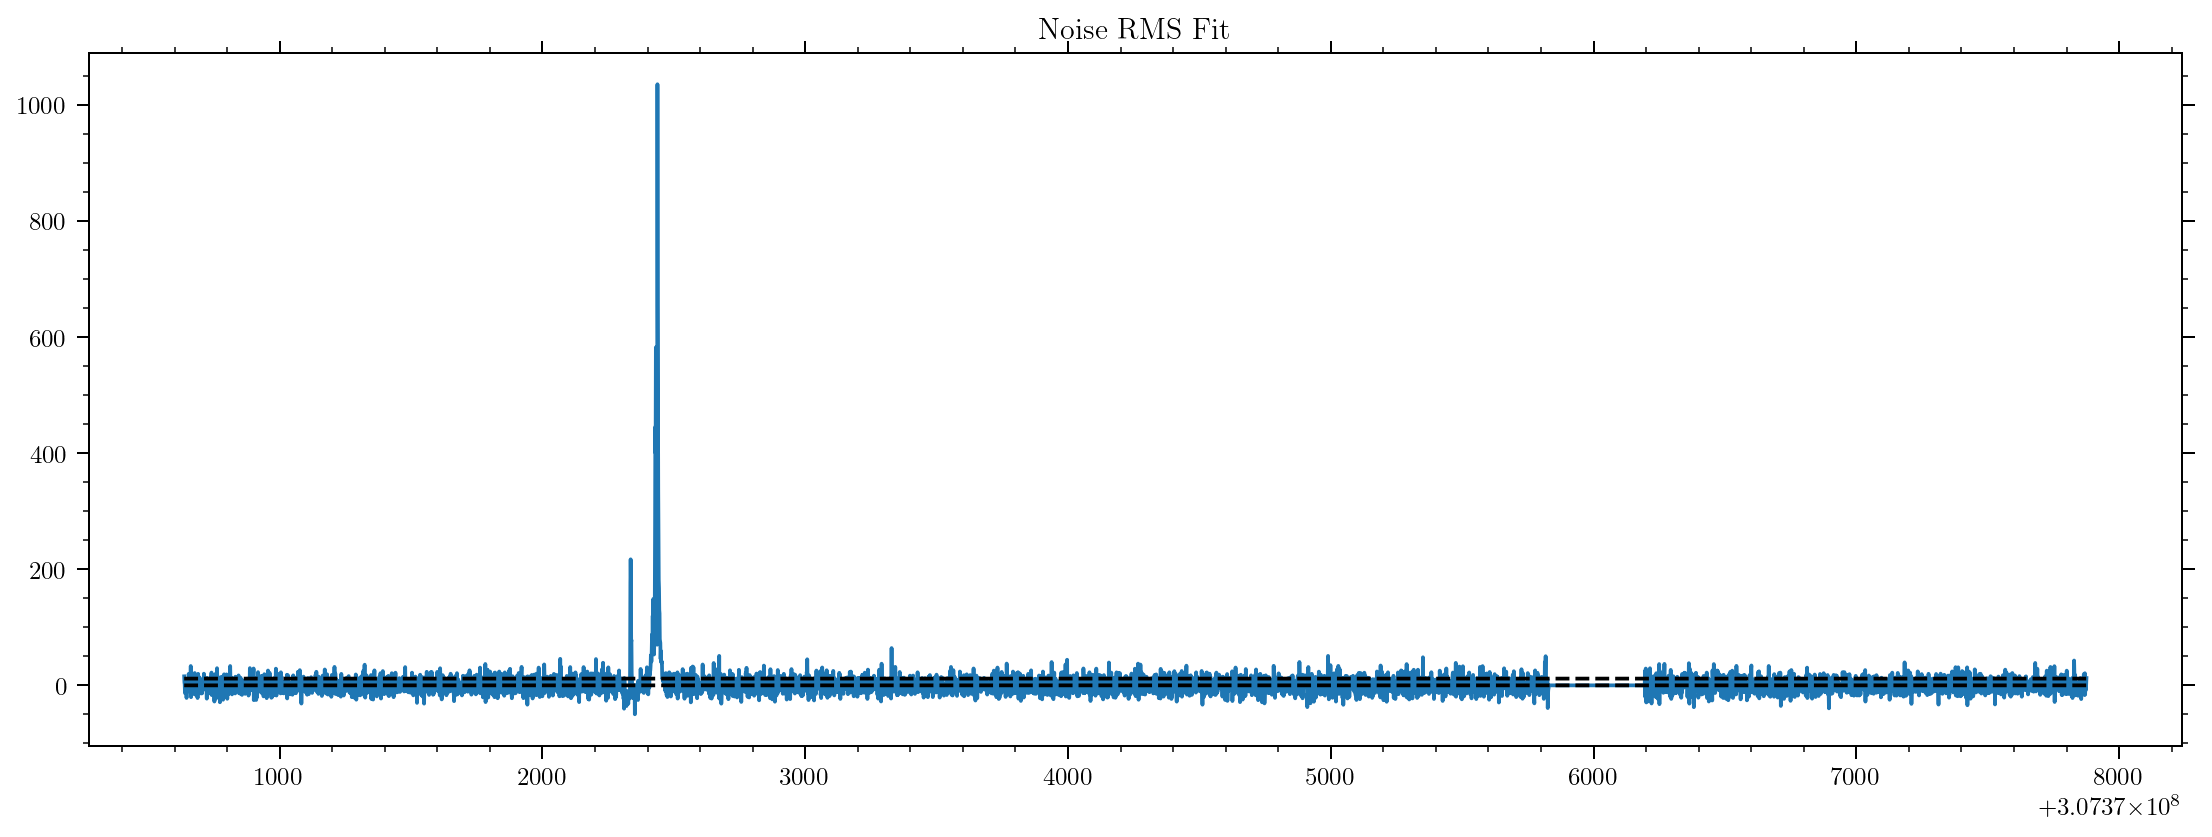

In [13]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc[0].field('TIME'), detrend_func(lc[0], saa_start_ind, saa_end_ind))
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*snr_rms(detrend_func(lc[0], saa_start_ind, saa_end_ind), saa_start_ind)[1], 'k--')
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*0, 'k--')
plt.title('Noise RMS Fit')
plt.show()

In [14]:
def gaussian_fit(lc_data, saa_start_ind, bins):
    saa_start_ind -= 20
    max_ind = int(np.where(lc_data == np.max(lc_data))[0])
    x_data = lc_data[max_ind+15:saa_start_ind]
    hist, bin_edges = np.histogram(x_data, bins)
    n = len(hist)
    x_hist=np.zeros(n)
    for i in range(n):
        x_hist[i]=(bin_edges[i+1]+bin_edges[i])/2
        
    y_hist=hist

    def gaus(X,C,X_mean,sigma):
        return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

    popt,pcov = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma])

    x_hist_2=np.linspace(np.min(x_hist),np.max(x_hist),500)

    return (popt, x_hist_2, gaus(x_hist_2, *popt), x_data)

In [15]:
def snr_gauss(lc_data, saa_start_ind, bins):
    A, noise_mean, noise_std = gaussian_fit(lc_data, saa_start_ind, bins)[0]
    noise_gauss = np.abs(noise_mean+3*noise_std)
    peak = np.max(lc_data)
    return ((peak/(noise_gauss)), noise_gauss)

In [16]:
for i in range(0,4):
    print("[Noise Gaussian-fit] SNR of Q"+str(i)+" = "+str(snr_gauss(detrend_func(lc[i], saa_start_ind, saa_end_ind), saa_start_ind, 100)[0]))

[Noise Gaussian-fit] SNR of Q0 = 31.003417801485035
[Noise Gaussian-fit] SNR of Q1 = 25.624019215580677
[Noise Gaussian-fit] SNR of Q2 = 54.903237245568725
[Noise Gaussian-fit] SNR of Q3 = 35.525704877905255


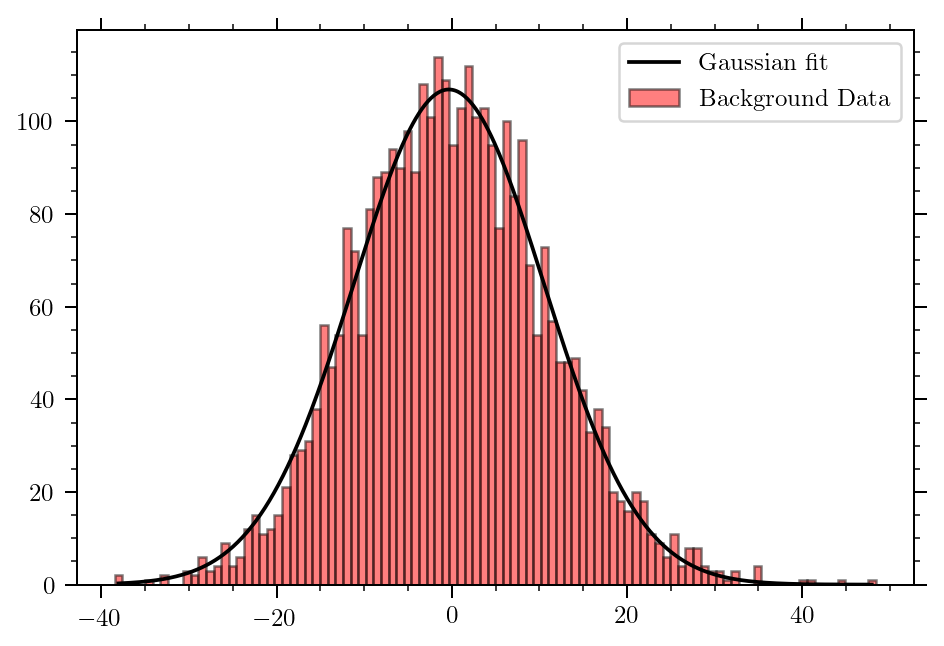

In [17]:
bins=100
plt.figure(dpi=180, figsize=(6,4))
popt, x_hist, y_hist, x_data = gaussian_fit(detrend_func(lc[1], saa_start_ind, saa_end_ind), saa_start_ind, bins )
plt.plot(x_hist,y_hist,label='Gaussian fit', c='black')
plt.hist(x_data,bins=100, label='Background Data', edgecolor='black', color='red', alpha=0.5)
plt.legend()
plt.show()

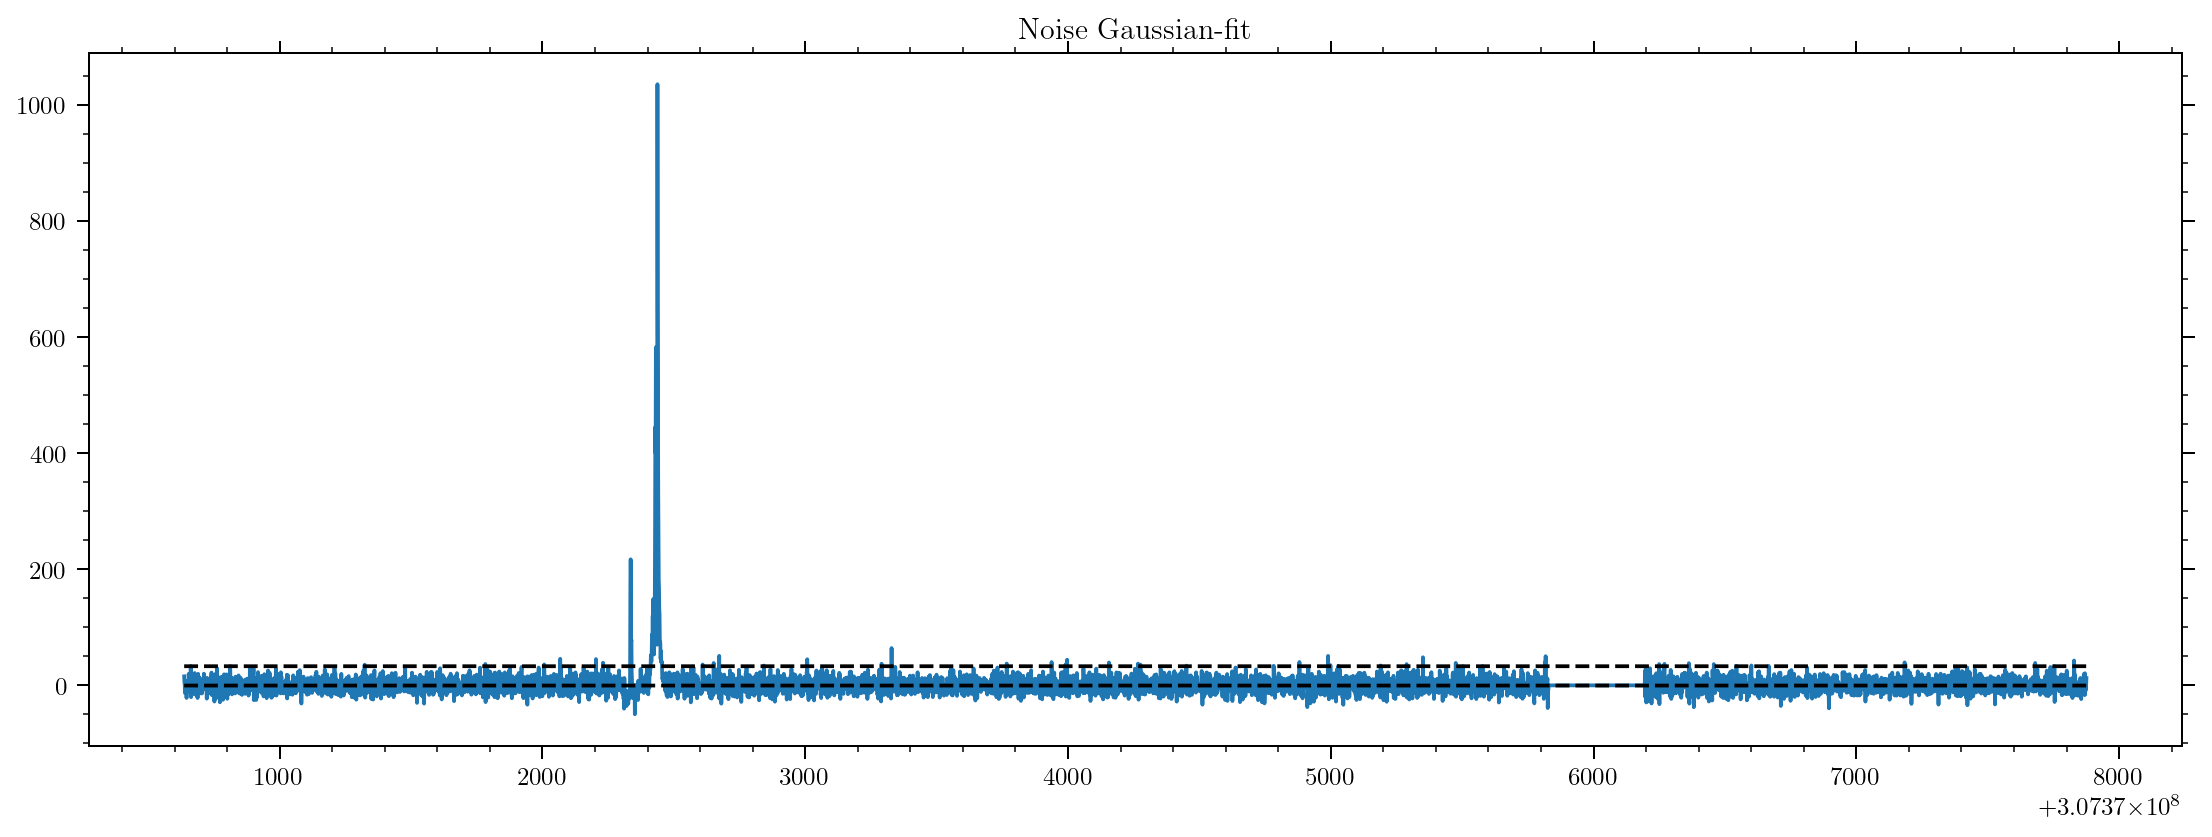

In [18]:
C, mean, std = popt
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc[0].field('TIME'), detrend_func(lc[0], saa_start_ind, saa_end_ind))
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*np.abs(mean+3*std), 'k--')
plt.plot(lc[0].field('TIME'), np.ones_like(lc[0].field('TIME'))*mean, 'k--')
plt.title('Noise Gaussian-fit')
plt.show()

In [19]:
from scipy.special import factorial
from scipy.stats import poisson

In [20]:
def poisson_fit(lc_data, saa_start_ind, bins):
    saa_start_ind -= 20
    max_ind = int(np.where(lc_data == np.max(lc_data))[0])
    x_data = lc_data[max_ind+15:saa_start_ind]
    hist, bin_edges = np.histogram(x_data, bins)
    n = len(hist)
    x_hist=np.zeros(n)
    for i in range(n):
        x_hist[i]=(bin_edges[i+1]+bin_edges[i])/2

    x_hist = np.array([int(x_hist[i]) for i in range(0, np.size(x_hist))])
    y_hist=hist
    offset = np.std(x_data)**2
    x_hist = x_hist + offset
    
    def pois(X, C, l):
        return C*poisson.pmf(X,l)

    mean = sum(x_hist*y_hist)/sum(y_hist)                  
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist) 

    popt,pcov = curve_fit(pois,x_hist.astype(int),y_hist, p0=[max(y_hist), offset])

    x_hist_2=np.arange(int(np.min(x_hist)),int(np.max(x_hist)))

    return (popt, x_hist_2, pois(x_hist_2, *popt), x_data, offset)

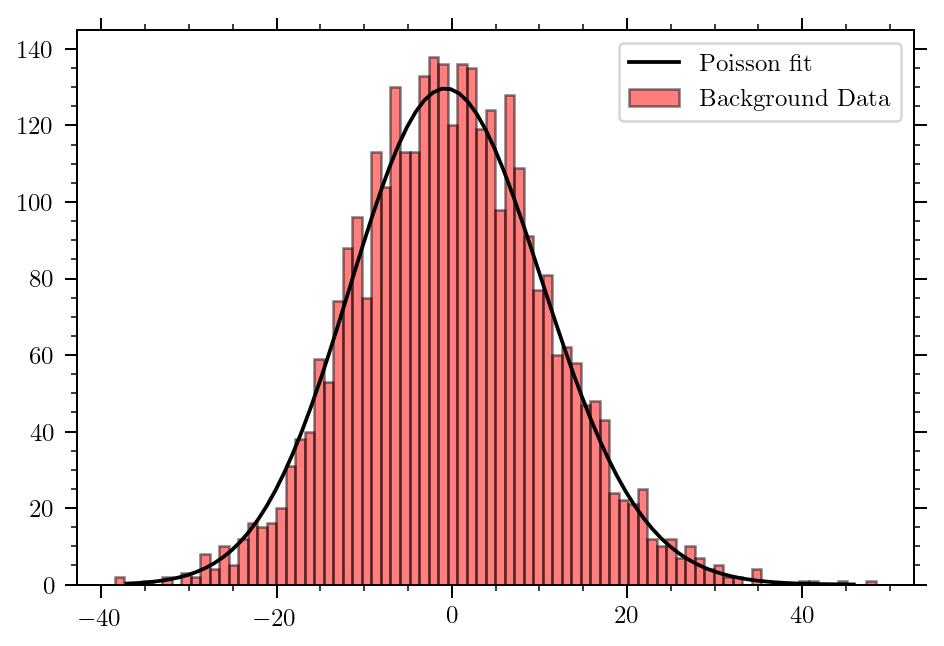

In [21]:
bins=80
plt.figure(dpi=180, figsize=(6,4))
popt, x_hist, y_hist, x_data, offset = poisson_fit(detrend_func(lc[1], saa_start_ind, saa_end_ind), saa_start_ind, bins)
plt.plot(x_hist-offset,y_hist,label='Poisson fit', c='black')
plt.hist(x_data,bins=bins, label='Background Data', edgecolor='black', color='red', alpha=0.5)
plt.legend()
plt.show()

In [22]:
def snr_poisson(lc_data, saa_start_ind, bins):
    A, noise_mean = poisson_fit(lc_data, saa_start_ind, bins)[0]
    noise_std = np.sqrt(noise_mean)
    noise_gauss = np.abs((noise_mean-bins+0.5)+3*noise_std)
    peak = np.max(lc_data)
    return ((peak/(noise_gauss)), noise_gauss)

In [23]:
for i in range(0,4):
    print("[Noise Poisson-fit] SNR of Q"+str(i)+" = "+str(snr_poisson(detrend_func(lc[i], saa_start_ind, saa_end_ind), saa_start_ind, bins)[0]))

[Noise Poisson-fit] SNR of Q0 = 11.802547205533983
[Noise Poisson-fit] SNR of Q1 = 11.529781813421454
[Noise Poisson-fit] SNR of Q2 = 21.44357551418544
[Noise Poisson-fit] SNR of Q3 = 16.383009477184235


In [24]:
lc1_0p1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_0p1_Q0.lc')
lc2_0p1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_0p1_Q1.lc')
lc3_0p1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_0p1_Q2.lc')
lc4_0p1 = fits.open('AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_0p1_Q3.lc')

In [25]:
lc1_0p1_data = lc1_0p1[1].data
lc2_0p1_data = lc2_0p1[1].data
lc3_0p1_data = lc3_0p1[1].data
lc4_0p1_data = lc4_0p1[1].data

lc_0p1 = [lc1_0p1_data, lc2_0p1_data, lc3_0p1_data, lc4_0p1_data]

In [26]:
saa_start_0p1_ind = np.where(np.round(lc_0p1[0].field('TIME'),1)==saa_start)[0][0]
saa_start_0p1_time = lc_0p1[0].field('TIME')[saa_start_0p1_ind]
saa_end_0p1_ind = np.where(np.round(lc_0p1[0].field('TIME'),1)==saa_end)[0][0]
saa_end_0p1_time = lc_0p1[0].field('TIME')[saa_end_0p1_ind]

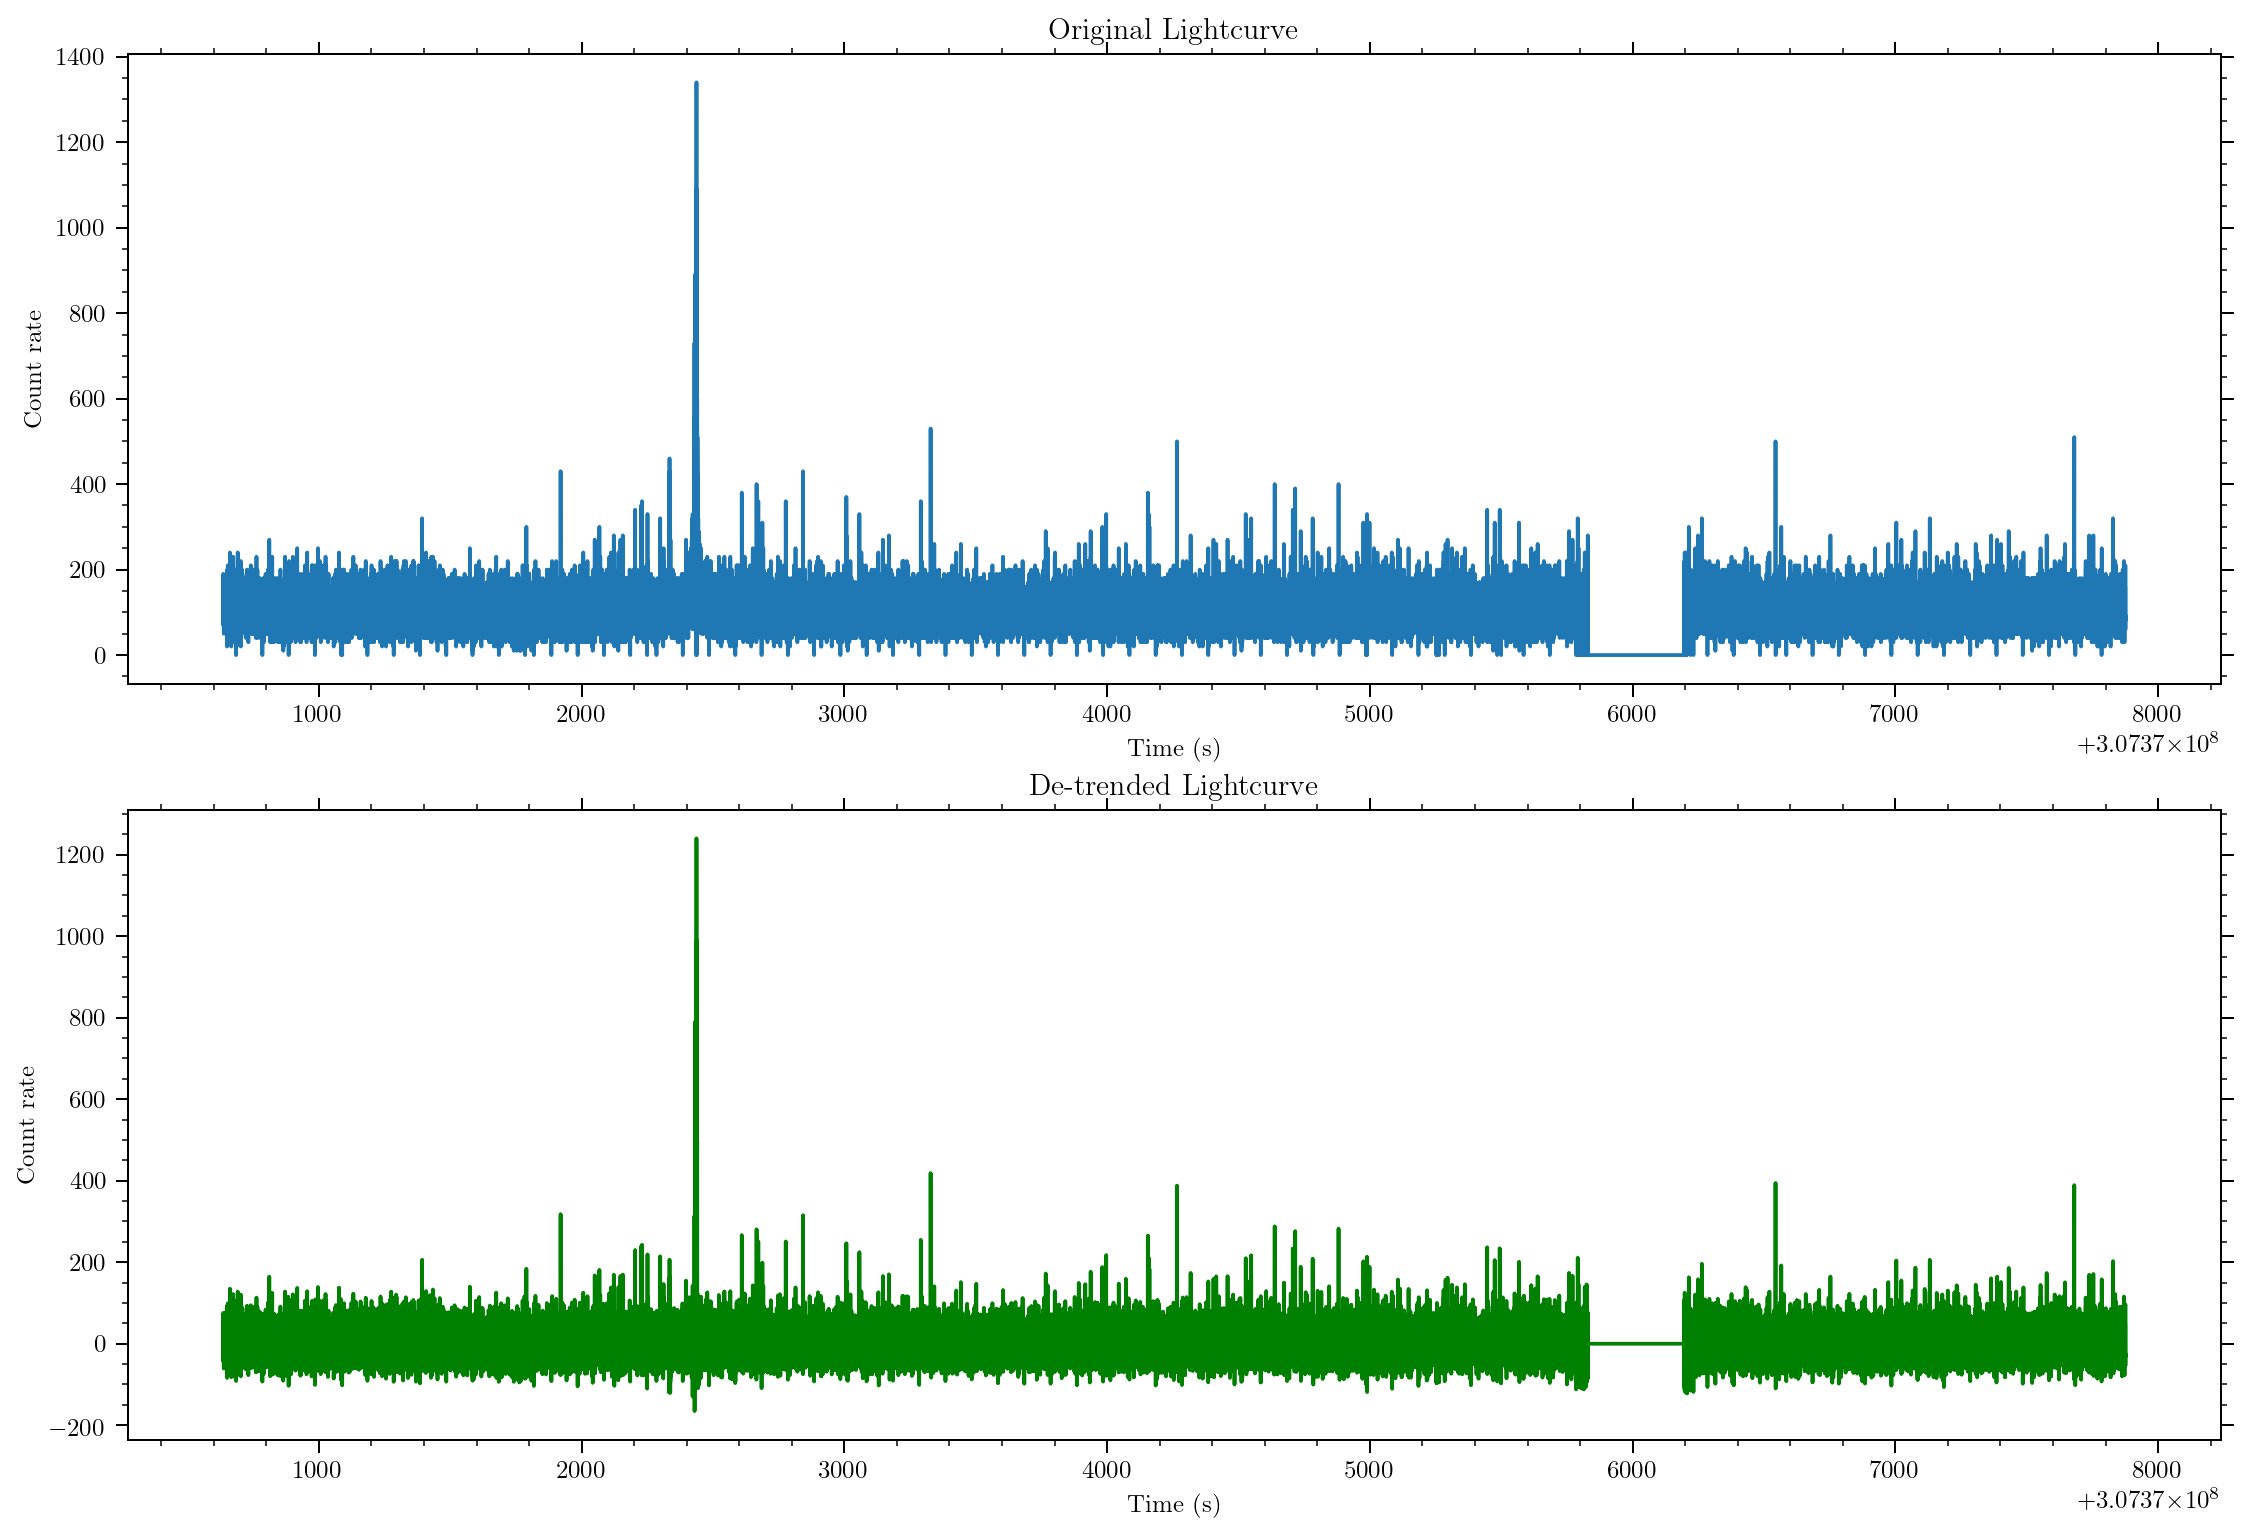

In [27]:
plt.figure(dpi=180, figsize=(15,10))
plt.subplot(2,1,1)
plt.title('Original Lightcurve')
plt.plot(lc_0p1[0].field('TIME'), lc_0p1[0].field('RATE'))
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.subplot(2,1,2)
plt.title('De-trended Lightcurve')
plt.plot(lc_0p1[0].field('TIME'), detrend_func(lc_0p1[0], saa_start_0p1_ind, saa_end_0p1_ind), 'g')
plt.xlabel('Time (s)')
plt.ylabel('Count rate')
plt.show()

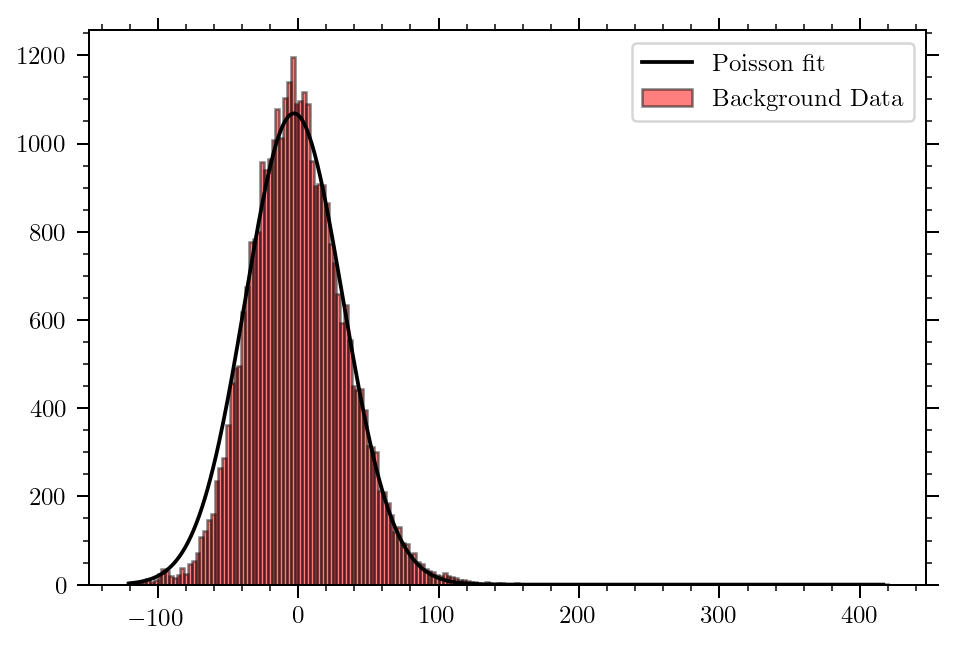

In [28]:
bins=200
plt.figure(dpi=180, figsize=(6,4))
popt, x_hist, y_hist, x_data, offset = poisson_fit(detrend_func(lc_0p1[1], saa_start_0p1_ind, saa_end_0p1_ind), saa_start_0p1_ind, bins)
plt.plot(x_hist-offset,y_hist,label='Poisson fit', c='black')
plt.hist(x_data,bins=bins, label='Background Data', edgecolor='black', color='red', alpha=0.5)
plt.legend()
plt.show()

In [29]:
def bindata(data, t, time):
    n = int(time/t)
    rebin_data = [np.average(data[i:i+n]) for i in range(0, len(data), n)]
    return (np.array(rebin_data))

In [30]:
test_data = bindata(lc_0p1[0].field('RATE'), 0.1, 1)

In [31]:
max_ind = int(np.where(lc[0].field('RATE') == np.max(lc[0].field('RATE')))[0])

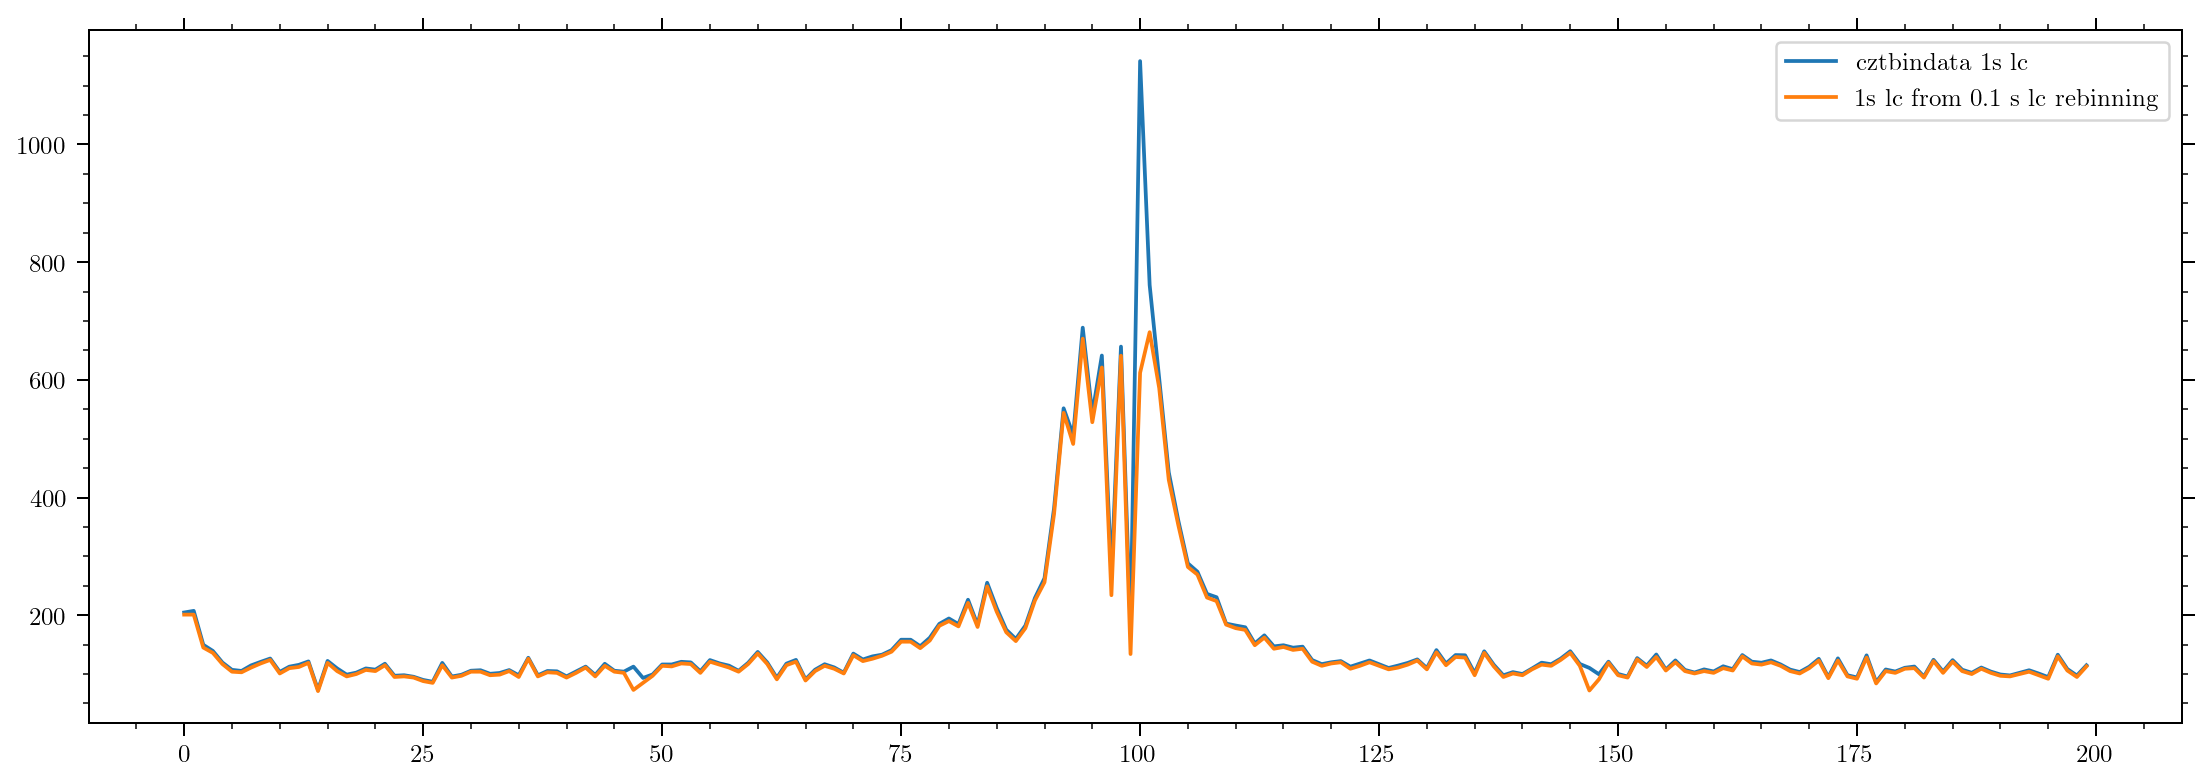

In [32]:
plt.figure(dpi=180, figsize=(15,5))
plt.plot(lc[0].field('RATE')[max_ind-100:max_ind+100])
plt.plot(test_data[max_ind-100:max_ind+100])
plt.legend(['cztbindata 1s lc', '1s lc from 0.1 s lc rebinning'])
plt.show()

In [33]:
for i in range(0,4):
    print("[Noise Max-Min] SNR of Q"+str(i)+" = "+str(snr_maxmin(detrend_func(lc_0p1[i], saa_start_0p1_ind, saa_end_0p1_ind), saa_start_0p1_ind)[0]))

[Noise Max-Min] SNR of Q0 = 1.6348122
[Noise Max-Min] SNR of Q1 = 1.7704198
[Noise Max-Min] SNR of Q2 = 1.9889021
[Noise Max-Min] SNR of Q3 = 0.88448584


In [34]:
for i in range(0,4):
    print("[Noise RMS] SNR of Q"+str(i)+" = "+str(snr_rms(detrend_func(lc_0p1[i], saa_start_0p1_ind, saa_end_0p1_ind), saa_start_0p1_ind)[0]))

[Noise RMS] SNR of Q0 = 34.05363109882734
[Noise RMS] SNR of Q1 = 27.59738360828373
[Noise RMS] SNR of Q2 = 52.33115992748253
[Noise RMS] SNR of Q3 = 33.38167328894053


In [35]:
bins = 80
for i in range(0,4):
    print("[Noise Gaussian-fit] SNR of Q"+str(i)+" = "+str(snr_gauss(detrend_func(lc_0p1[i], saa_start_0p1_ind, saa_end_0p1_ind), saa_start_0p1_ind, bins)[0]))

[Noise Gaussian-fit] SNR of Q0 = 13.219804750311791
[Noise Gaussian-fit] SNR of Q1 = 10.039945353337407
[Noise Gaussian-fit] SNR of Q2 = 19.75097046375226
[Noise Gaussian-fit] SNR of Q3 = 12.203127384121489
